<a href="https://colab.research.google.com/github/haset-of-pop/Stock_Sentiment_Analysis/blob/main/Stock_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import yfinance as yf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import spacy
import numpy as np
#nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from ta.momentum import RSIIndicator

import requests
def extract_data(year, month, api_key):
    url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        api_data = data['response']['docs']
        return api_data
    else:
        print(f"Failed to fetch data for {year}-{month}: {response.status_code}")
        return []

In [ ]:
all_headlines = []
all_datetime=[]
api_key="of9VIAr7muye3G5DR1GxbR71TPCnFHIy"
for year in range(2006,2020):
    for month in range(1,13):
        print(f"Fetching data for {year}-{month}")
        try:
            api_data = extract_data(year, month, api_key)
            if api_data:
                all_headlines.extend([data['headline']['main'] for data in api_data])
                all_datetime.extend([data['pub_date'] for data in api_data])
        except Exception as e:
            print(f"Error in extacting data for {year}-{month}: {e}")

Fetching data for 2006-1
Fetching data for 2006-2
Fetching data for 2006-3
Fetching data for 2006-4
Fetching data for 2006-5
Fetching data for 2006-6
Failed to fetch data for 2006-6: 429
Fetching data for 2006-7
Failed to fetch data for 2006-7: 429
Fetching data for 2006-8
Failed to fetch data for 2006-8: 429
Fetching data for 2006-9
Failed to fetch data for 2006-9: 429
Fetching data for 2006-10
Failed to fetch data for 2006-10: 429
Fetching data for 2006-11
Failed to fetch data for 2006-11: 429
Fetching data for 2006-12
Failed to fetch data for 2006-12: 429
Fetching data for 2007-1
Failed to fetch data for 2007-1: 429
Fetching data for 2007-2
Failed to fetch data for 2007-2: 429
Fetching data for 2007-3
Failed to fetch data for 2007-3: 429
Fetching data for 2007-4
Failed to fetch data for 2007-4: 429
Fetching data for 2007-5
Failed to fetch data for 2007-5: 429
Fetching data for 2007-6
Failed to fetch data for 2007-6: 429
Fetching data for 2007-7
Failed to fetch data for 2007-7: 429
F

In [ ]:
df= pd.DataFrame({"Datetime": all_datetime, "Headlines":all_headlines})

In [ ]:
df['Datetime']= pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date

In [ ]:
df.head

<bound method NDFrame.head of                        Datetime  \
0     2006-01-01 05:00:00+00:00   
1     2006-01-01 05:00:00+00:00   
2     2006-01-01 05:00:00+00:00   
3     2006-01-01 05:00:00+00:00   
4     2006-01-01 05:00:00+00:00   
...                         ...   
60184 2006-05-31 21:40:40+00:00   
60185 2006-05-31 22:43:08+00:00   
60186 2006-05-31 22:53:09+00:00   
60187 2006-05-31 23:05:54+00:00   
60188 2006-05-31 23:58:06+00:00   

                                               Headlines        date  
0                  Top Democrat seeks wider NSA hearings  2006-01-01  
1         A Bar of Stiff Drinks Shakes Up a Cocktail Mix  2006-01-01  
2      Alan M. Voorhees Is Dead at 83; Designed Trans...  2006-01-01  
3             Ready for Everything Under the Solar Panel  2006-01-01  
4                          BEST SELLERS: January 1, 2006  2006-01-01  
...                                                  ...         ...  
60184                               TurnHere Video Tours  2006-05-31  
60185                 A Tale of Installation Frustration  2006-05-31  
60186                               Farsi Match-Tracking  2006-05-31  
60187                                       Radio, Radio  2006-05-31  
60188                                   Tropical Arctic?  2006-05-31  

[60189 rows x 3 columns]>

In [ ]:
def contains_keywords(text):
    for keyword in keywords:
        if keyword.lower() in text.lower():
            return True
    return False
keywords =['data breach', 'user privacy' , 'Cambridge Analytica', 'antitrust' ,'FTC investigation' ,'Congress', 'GDPR', 'quarterly earnings', 'profit', 'Revenue','Mark Zuckerberg', 'cybersecurity', 'hacking', 'acquisition',
    'Facebook', 'Meta', 'Whatsapp', 'Instagram',
    'MetaVerse', 'innovation', 'techonology']
df['contains_keywords'] = df['Headlines'].apply(contains_keywords)

In [ ]:
filtered_df = df[df['contains_keywords']]
filtered_df = filtered_df.drop(columns=['contains_keywords', "Datetime"]).reset_index(drop = True )
filtered_df = filtered_df[['date', 'Headlines']]
filtered_df.head()

,date,Headlines
0,2014-01-02,Newark Recalls Its Lustrous Metals Past
1,2014-01-02,Edward Steichen in the 1920s and 1930s: A Rece...
2,2014-01-03,When a 2nd-Term President and a Divided Congre...
3,2014-01-03,Today’s Scuttlebot: Facebook Privacy and Shark...
4,2014-01-04,Obama Urges Congress to Restore Unemployment B...


In [ ]:
facebook_news1=filtered_df.copy()

In [ ]:
facebook_news1

,date,Headlines
0,2014-01-02,Newark Recalls Its Lustrous Metals Past
1,2014-01-02,Edward Steichen in the 1920s and 1930s: A Rece...
2,2014-01-03,When a 2nd-Term President and a Divided Congre...
3,2014-01-03,Today’s Scuttlebot: Facebook Privacy and Shark...
4,2014-01-04,Obama Urges Congress to Restore Unemployment B...
...,...,...
414,2014-05-28,"A Do-Nothing Congress? Well, Pretty Close"
415,2014-05-28,New Standards for Companies’ Revenue Accountin...
416,2014-05-28,Facebook Wants European Blessing for WhatsApp ...
417,2014-05-29,Primary Loss Means End of Era for World War II...


In [ ]:
all_headlines = []
all_datetime=[]
api_key="of9VIAr7muye3G5DR1GxbR71TPCnFHIy"
for year in range(2020,2025):
    for month in range(1,13):
        print(f"Fetching data for {year}-{month}")
        try:
            api_data = extract_data(year, month, api_key)
            if api_data:
                all_headlines.extend([data['headline']['main'] for data in api_data])
                all_datetime.extend([data['pub_date'] for data in api_data])
        except Exception as e:
            print(f"Error in extacting data for {year}-{month}: {e}")

Fetching data for 2020-1
Fetching data for 2020-2
Fetching data for 2020-3
Fetching data for 2020-4
Fetching data for 2020-5
Fetching data for 2020-6
Failed to fetch data for 2020-6: 429
Fetching data for 2020-7
Failed to fetch data for 2020-7: 429
Fetching data for 2020-8
Failed to fetch data for 2020-8: 429
Fetching data for 2020-9
Failed to fetch data for 2020-9: 429
Fetching data for 2020-10
Failed to fetch data for 2020-10: 429
Fetching data for 2020-11
Failed to fetch data for 2020-11: 429
Fetching data for 2020-12
Failed to fetch data for 2020-12: 429
Fetching data for 2021-1
Failed to fetch data for 2021-1: 429
Fetching data for 2021-2
Failed to fetch data for 2021-2: 429
Fetching data for 2021-3
Failed to fetch data for 2021-3: 429
Fetching data for 2021-4
Failed to fetch data for 2021-4: 429
Fetching data for 2021-5
Failed to fetch data for 2021-5: 429
Fetching data for 2021-6
Failed to fetch data for 2021-6: 429
Fetching data for 2021-7
Failed to fetch data for 2021-7: 429
F

In [ ]:
df= pd.DataFrame({"Datetime": all_datetime, "Headlines":all_headlines})
df['Datetime']= pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date
df['contains_keywords'] = df['Headlines'].apply(contains_keywords)
filtered_df = df[df['contains_keywords']]
filtered_df = filtered_df.drop(columns=['contains_keywords', "Datetime"]).reset_index(drop = True )
filtered_df = filtered_df[['date', 'Headlines']]
filtered_df.head()

,date,Headlines
0,2020-01-03,U.S. Strike on Iranian General Divides Congress
1,2020-01-03,Congressional Leaders Call for Details After U...
2,2020-01-03,"Phil Roe, Tennessee Republican, Announces Reti..."
3,2020-01-04,White House Notifies Congress of Suleimani Str...
4,2020-01-05,"Congress, Stop President Trump’s Rush to War W..."


In [ ]:

facebook_news2=filtered_df.copy()

In [ ]:
all_headlines = []
all_datetime=[]
api_key="of9VIAr7muye3G5DR1GxbR71TPCnFHIy"
for year in range(2010,2014):
    for month in range(1,13):
        print(f"Fetching data for {year}-{month}")
        try:
            api_data = extract_data(year, month, api_key)
            if api_data:
                all_headlines.extend([data['headline']['main'] for data in api_data])
                all_datetime.extend([data['pub_date'] for data in api_data])
        except Exception as e:
            print(f"Error in extacting data for {year}-{month}: {e}")

Fetching data for 2010-1
Failed to fetch data for 2010-1: 429
Fetching data for 2010-2
Failed to fetch data for 2010-2: 429
Fetching data for 2010-3
Failed to fetch data for 2010-3: 429
Fetching data for 2010-4
Failed to fetch data for 2010-4: 429
Fetching data for 2010-5
Failed to fetch data for 2010-5: 429
Fetching data for 2010-6
Failed to fetch data for 2010-6: 429
Fetching data for 2010-7
Failed to fetch data for 2010-7: 429
Fetching data for 2010-8
Failed to fetch data for 2010-8: 429
Fetching data for 2010-9
Failed to fetch data for 2010-9: 429
Fetching data for 2010-10
Failed to fetch data for 2010-10: 429
Fetching data for 2010-11
Failed to fetch data for 2010-11: 429
Fetching data for 2010-12
Failed to fetch data for 2010-12: 429
Fetching data for 2011-1
Failed to fetch data for 2011-1: 429
Fetching data for 2011-2
Failed to fetch data for 2011-2: 429
Fetching data for 2011-3
Failed to fetch data for 2011-3: 429
Fetching data for 2011-4
Failed to fetch data for 2011-4: 429
Fe

In [ ]:
df= pd.DataFrame({"Datetime": all_datetime, "Headlines":all_headlines})
df['Datetime']= pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date
df['contains_keywords'] = df['Headlines'].apply(contains_keywords)
filtered_df = df[df['contains_keywords']]
filtered_df = filtered_df.drop(columns=['contains_keywords', "Datetime"]).reset_index(drop = True )
filtered_df = filtered_df[['date', 'Headlines']]
filtered_df.head()

,date,Headlines
0,2010-01-05,"Think, an Electric Car, to Be Built in Indiana"
1,2010-01-07,Q&A: Google’s Green Energy Czar
2,2010-01-07,A Chat With Google’s Green Energy Czar
3,2010-01-08,Study Raises Cost Estimate for Electric Cars
4,2010-01-08,White House Awards $2.3 Billion in Tax Credits...


In [ ]:

facebook_news3=filtered_df.copy()

In [ ]:
df=[facebook_news3,facebook_news1,facebook_news2]
facebook_news_final = pd.concat(df).reset_index(drop = True )
facebook_news_final.to_csv("facebook_news.csv")

In [ ]:
facebook_news_final

,date,Headlines
0,2010-01-05,"Think, an Electric Car, to Be Built in Indiana"
1,2010-01-07,Q&A: Google’s Green Energy Czar
2,2010-01-07,A Chat With Google’s Green Energy Czar
3,2010-01-08,Study Raises Cost Estimate for Electric Cars
4,2010-01-08,White House Awards $2.3 Billion in Tax Credits...
...,...,...
1510,2024-06-13,Tesla’s Nordic Shareholders Seek to Promote Wo...
1511,2024-06-13,Tesla Shareholders Approve Big Stock Package f...
1512,2024-06-14,Musk’s Tesla Pay Package Got Big Margin in Sha...
1513,2024-06-14,What Elon Musk’s Convincing Win Means for Tesla


In [ ]:
df=facebook_news_final
combined_news_df = df.groupby('date')['Headlines'].agg(' ; '.join).reset_index()


In [ ]:
combined_news_df.duplicated().sum()

0

In [ ]:
combined_news_df["Date"]=combined_news_df["date"]
combined_news_df['Date'] = pd.to_datetime(combined_news_df['Date'])
combined_news_df.drop(columns="date")


,Headlines,Date
0,"Think, an Electric Car, to Be Built in Indiana",2010-01-05
1,Q&A: Google’s Green Energy Czar ; A Chat With ...,2010-01-07
2,Study Raises Cost Estimate for Electric Cars ;...,2010-01-08
3,"New York Ripe for Electric Cars, Study Says",2010-01-11
4,Detroit Auto Show: Tesla Model S Prototype,2010-01-12
...,...,...
1049,U.A.W. Reaches Accord on Pay and Safety at E.V...,2024-06-10
1050,"To Understand Elon Musk’s Descent, Look at His...",2024-06-11
1051,What to Know About Europe’s Extra Tariffs on C...,2024-06-12
1052,Tesla Share Price Is Its Own Referendum on Mus...,2024-06-13


In [ ]:
!pip install yfinance


In [ ]:
ticker_symbol = 'facebook'
start_date = '2010-01-04'
end_date = '2024-4-24'
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [ ]:
merged_df = pd.merge(combined_news_df, stock_data, on='Date', how='inner')

In [ ]:
final_df=merged_df.copy()

In [ ]:
df = final_df
df

,date,Headlines,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,Tesla Shares Zoom Higher in First Day of Tradi...,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,Tesla Leaves I.P.O. Price in the Dust,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-02,"Latest Electric Car Will Be a BMW, From the Ba...",2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
3,2010-07-07,Tesla Motors Shares Drop Below Initial Sale Price,2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500
4,2010-07-08,Will Electric Cars Cause More Summer Power Out...,2010-07-08,1.076000,1.168000,1.038000,1.164000,1.164000,115671000
...,...,...,...,...,...,...,...,...,...
805,2024-04-16,Has Tesla Peaked?,2024-04-16,156.740005,158.190002,153.750000,157.110001,157.110001,97000000
806,2024-04-17,Tesla Sets Up a New Showdown Over Elon Musk’s ...,2024-04-17,157.639999,158.330002,153.779999,155.449997,155.449997,82439700
807,2024-04-19,Tesla Will Recall Cybertruck in Latest Setback,2024-04-19,148.970001,150.940002,146.220001,147.050003,147.050003,86005100
808,2024-04-22,How Can Elon Musk Reassure Tesla Investors? ; ...,2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600


In [ ]:
final_df.to_csv("final dataset.csv")


In [ ]:
df=pd.read_csv("final dataset.csv")

In [ ]:


#uncomment if not already downloaded
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#!python -m spacy download en_core_web_sm


stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc ]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text
df['Processed Headlines'] = df['Headlines'].apply(preprocess_text)


In [ ]:
df.shape


(810, 11)

In [ ]:


df['Date'] = pd.to_datetime(df['Date'])
df['SMA5'] = df['Close'].rolling(window=5).mean()
df['SMA2'] = df['Close'].rolling(window=2).mean()
df['close_diff'] = df['Close'].diff()

# Calculate RSI
rsi = RSIIndicator(close=df['Close'], window=14)
df['rsi'] = rsi.rsi()

# Function to get sentiment label based on close difference
def get_sentiment_label(diff):
    if diff > 0:
        return 'Positive'
    elif diff < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['Movement'] = df['close_diff'].apply(lambda x: get_sentiment_label(x) if pd.notnull(x) else 'Neutral')
sid = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['Headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['neg'] = df['Headlines'].apply(lambda x: sid.polarity_scores(x)['neg'])
df['pos'] = df['Headlines'].apply(lambda x: sid.polarity_scores(x)['pos'])
df['neu'] = df['Headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])


df['Subjectivity'] = df['Headlines'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
df['Polarity'] =df['Headlines'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [ ]:
df_cleaned = df.dropna()

In [ ]:
df=df_cleaned.reset_index(drop=True)
df.head()

,Unnamed: 0,date,Headlines,Date,Open,High,Low,Close,Adj Close,Volume,...,SMA2,close_diff,rsi,Movement,sentiment_scores,neg,pos,neu,Subjectivity,Polarity
0,13,2010-07-29,Off the Menu: Three New Restaurants for Batter...,2010-07-29,1.384667,1.392000,1.333333,1.356667,1.356667,9240000,...,1.376667,-0.040000,43.893432,Negative,0.0000,0.00,0.000,0.0000,0.454545,0.136364
1,14,2010-07-30,Goldman Sachs Remaking a Hub in Battery Park City,2010-07-30,1.346667,1.362667,1.303333,1.329333,1.329333,6403500,...,1.343000,-0.027334,41.681556,Negative,0.0000,0.00,0.000,0.0000,0.000000,0.000000
2,15,2010-08-03,A Bet on Clean Energy in the Automotive State,2010-08-03,1.400000,1.463333,1.388000,1.463333,1.463333,18457500,...,1.396333,0.134000,53.936321,Positive,0.5859,0.00,0.444,0.5859,0.700000,0.366667
3,16,2010-08-04,"Fairies, Goblins and a Thumb-Sucking Hero in B...",2010-08-04,1.463333,1.478667,1.390000,1.417333,1.417333,13695000,...,1.440333,-0.046000,50.048322,Negative,0.5574,0.00,0.310,0.5574,0.000000,0.000000
4,17,2010-08-05,Tesla Reports Higher Losses in 2nd Quarter ; T...,2010-08-05,1.436000,1.436667,1.336667,1.363333,1.363333,11943000,...,1.390333,-0.054000,45.868303,Negative,-0.6597,0.31,0.000,-0.6597,0.250000,0.125000


In [ ]:
df

,Unnamed: 0,date,Headlines,Date,Open,High,Low,Close,Adj Close,Volume,...,SMA2,close_diff,rsi,Movement,sentiment_scores,neg,pos,neu,Subjectivity,Polarity
0,13,2010-07-29,Off the Menu: Three New Restaurants for Batter...,2010-07-29,1.384667,1.392000,1.333333,1.356667,1.356667,9240000,...,1.376667,-0.040000,43.893432,Negative,0.0000,0.000,0.000,0.0000,0.454545,0.136364
1,14,2010-07-30,Goldman Sachs Remaking a Hub in Battery Park City,2010-07-30,1.346667,1.362667,1.303333,1.329333,1.329333,6403500,...,1.343000,-0.027334,41.681556,Negative,0.0000,0.000,0.000,0.0000,0.000000,0.000000
2,15,2010-08-03,A Bet on Clean Energy in the Automotive State,2010-08-03,1.400000,1.463333,1.388000,1.463333,1.463333,18457500,...,1.396333,0.134000,53.936321,Positive,0.5859,0.000,0.444,0.5859,0.700000,0.366667
3,16,2010-08-04,"Fairies, Goblins and a Thumb-Sucking Hero in B...",2010-08-04,1.463333,1.478667,1.390000,1.417333,1.417333,13695000,...,1.440333,-0.046000,50.048322,Negative,0.5574,0.000,0.310,0.5574,0.000000,0.000000
4,17,2010-08-05,Tesla Reports Higher Losses in 2nd Quarter ; T...,2010-08-05,1.436000,1.436667,1.336667,1.363333,1.363333,11943000,...,1.390333,-0.054000,45.868303,Negative,-0.6597,0.310,0.000,-0.6597,0.250000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,805,2024-04-16,Has Tesla Peaked?,2024-04-16,156.740005,158.190002,153.750000,157.110001,157.110001,97000000,...,159.294998,-4.369995,38.556749,Negative,0.0000,0.000,0.000,0.0000,0.000000,0.000000
793,806,2024-04-17,Tesla Sets Up a New Showdown Over Elon Musk’s ...,2024-04-17,157.639999,158.330002,153.779999,155.449997,155.449997,82439700,...,156.279999,-1.660004,37.838033,Negative,-0.1531,0.197,0.094,-0.1531,0.454545,0.136364
794,807,2024-04-19,Tesla Will Recall Cybertruck in Latest Setback,2024-04-19,148.970001,150.940002,146.220001,147.050003,147.050003,86005100,...,151.250000,-8.399994,34.348851,Negative,0.0000,0.000,0.000,0.0000,0.900000,0.500000
795,808,2024-04-22,How Can Elon Musk Reassure Tesla Investors? ; ...,2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600,...,144.550003,-5.000000,32.431766,Negative,0.3400,0.000,0.118,0.3400,0.333333,0.250000


In [ ]:
facebook_stock_movement=df.copy()
facebook_stock_movement

,Unnamed: 0,date,Headlines,Date,Open,High,Low,Close,Adj Close,Volume,...,SMA2,close_diff,rsi,Movement,sentiment_scores,neg,pos,neu,Subjectivity,Polarity
0,13,2010-07-29,Off the Menu: Three New Restaurants for Batter...,2010-07-29,1.384667,1.392000,1.333333,1.356667,1.356667,9240000,...,1.376667,-0.040000,43.893432,Negative,0.0000,0.000,0.000,0.0000,0.454545,0.136364
1,14,2010-07-30,Goldman Sachs Remaking a Hub in Battery Park City,2010-07-30,1.346667,1.362667,1.303333,1.329333,1.329333,6403500,...,1.343000,-0.027334,41.681556,Negative,0.0000,0.000,0.000,0.0000,0.000000,0.000000
2,15,2010-08-03,A Bet on Clean Energy in the Automotive State,2010-08-03,1.400000,1.463333,1.388000,1.463333,1.463333,18457500,...,1.396333,0.134000,53.936321,Positive,0.5859,0.000,0.444,0.5859,0.700000,0.366667
3,16,2010-08-04,"Fairies, Goblins and a Thumb-Sucking Hero in B...",2010-08-04,1.463333,1.478667,1.390000,1.417333,1.417333,13695000,...,1.440333,-0.046000,50.048322,Negative,0.5574,0.000,0.310,0.5574,0.000000,0.000000
4,17,2010-08-05,Tesla Reports Higher Losses in 2nd Quarter ; T...,2010-08-05,1.436000,1.436667,1.336667,1.363333,1.363333,11943000,...,1.390333,-0.054000,45.868303,Negative,-0.6597,0.310,0.000,-0.6597,0.250000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,805,2024-04-16,Has Tesla Peaked?,2024-04-16,156.740005,158.190002,153.750000,157.110001,157.110001,97000000,...,159.294998,-4.369995,38.556749,Negative,0.0000,0.000,0.000,0.0000,0.000000,0.000000
793,806,2024-04-17,Tesla Sets Up a New Showdown Over Elon Musk’s ...,2024-04-17,157.639999,158.330002,153.779999,155.449997,155.449997,82439700,...,156.279999,-1.660004,37.838033,Negative,-0.1531,0.197,0.094,-0.1531,0.454545,0.136364
794,807,2024-04-19,Tesla Will Recall Cybertruck in Latest Setback,2024-04-19,148.970001,150.940002,146.220001,147.050003,147.050003,86005100,...,151.250000,-8.399994,34.348851,Negative,0.0000,0.000,0.000,0.0000,0.900000,0.500000
795,808,2024-04-22,How Can Elon Musk Reassure Tesla Investors? ; ...,2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600,...,144.550003,-5.000000,32.431766,Negative,0.3400,0.000,0.118,0.3400,0.333333,0.250000


In [ ]:
from nltk.tokenize import sent_tokenize
tokens=[]
for text in df['Processed Headlines']:
  sentences=sent_tokenize(text)
  for sentence in sentences:
    words=word_tokenize(sentence)
    tokens.append(words)

In [ ]:
import gensim
from gensim.models import word2vec
num_features = 300
num_processor = 4
context = 10
downsampling = 0.001
model = word2vec.Word2Vec(sentences=tokens, workers = num_processor,
                         vector_size = num_features,
                         window = context, sample = downsampling)

In [ ]:
vocab_size = len(model.wv.key_to_index)
print("Vocab size", vocab_size)

Vocab size 311


In [ ]:
def get_average_word2vec(text, model):
    # Tokenize the processed text
    tokens = word_tokenize(text.lower())

    # Filter tokens that are in the Word2Vec model's vocabulary
    valid_tokens = [token for token in tokens if token in model.wv]

    # If no valid tokens, return a zero vector
    if not valid_tokens:
        return np.zeros(model.vector_size)

    # Get embeddings for valid tokens
    embeddings = [model.wv[token] for token in valid_tokens]

    # Compute the average embedding
    avg_embedding = np.mean(embeddings, axis=0)

    return avg_embedding

# Calculate average Word2Vec embedding for the processed text
avg_embedding = df["Processed Headlines"].apply(lambda x:get_average_word2vec(x,model))

In [ ]:

df['avg_embedding']=avg_embedding
embedding_df = pd.DataFrame(df['avg_embedding'].to_list())
embedding_df.columns = [f'embedding_{i}' for i in range(embedding_df.shape[1])]

In [ ]:
embedding_df

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
0,0.019342,0.079334,0.020302,0.015353,0.019343,-0.044737,0.039331,0.155888,0.017579,-0.020075,...,0.011501,0.060353,0.030276,-0.005334,0.071736,0.072505,0.010807,-0.038424,0.028666,-0.020725
1,0.018447,0.075950,0.019938,0.014421,0.018928,-0.043234,0.037059,0.150408,0.016812,-0.019572,...,0.011129,0.058327,0.029579,-0.005256,0.069302,0.069323,0.010259,-0.036266,0.027663,-0.020139
2,0.015914,0.067875,0.019229,0.015420,0.014450,-0.040120,0.035541,0.135006,0.014141,-0.017216,...,0.010752,0.051405,0.025945,-0.006432,0.061861,0.064420,0.011721,-0.032717,0.025885,-0.017265
3,0.018447,0.075950,0.019938,0.014421,0.018928,-0.043234,0.037059,0.150408,0.016812,-0.019572,...,0.011129,0.058327,0.029579,-0.005256,0.069302,0.069323,0.010259,-0.036266,0.027663,-0.020139
4,0.018409,0.082063,0.020052,0.016125,0.020529,-0.047517,0.041931,0.158599,0.018834,-0.021765,...,0.012588,0.064283,0.031549,-0.005464,0.077071,0.075547,0.012127,-0.040534,0.029818,-0.023276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,0.050102,0.224194,0.057087,0.048164,0.055914,-0.130284,0.114774,0.436050,0.048527,-0.060823,...,0.037953,0.176303,0.082499,-0.017224,0.208616,0.207116,0.033945,-0.113547,0.084786,-0.064073
793,0.035222,0.147977,0.037214,0.032254,0.035882,-0.086962,0.076778,0.289818,0.031363,-0.039373,...,0.023879,0.116330,0.056156,-0.010565,0.137975,0.138720,0.023436,-0.073888,0.056531,-0.042387
794,0.024900,0.106173,0.027298,0.022692,0.027180,-0.063122,0.055681,0.209415,0.021229,-0.029459,...,0.017752,0.084835,0.039495,-0.008227,0.099433,0.098858,0.016391,-0.053834,0.040632,-0.031366
795,0.044472,0.183866,0.047276,0.042130,0.044583,-0.109205,0.094833,0.363764,0.038235,-0.048626,...,0.030091,0.145615,0.070921,-0.013830,0.173702,0.172826,0.028293,-0.092365,0.070907,-0.052733


In [ ]:
df2=df[['Date','Adj Close','sentiment_scores','Subjectivity','Polarity','neg','pos','neu',]]

In [ ]:
df['Movement']=df['Adj Close'].pct_change()


In [ ]:
label=[]
for i in df['Movement']:
  if i>0:
    label.append(1)
  else :
    label.append(0)

In [ ]:
df2['label']=label

C:\Users\risha\AppData\Local\Temp\ipykernel_15244\803124527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label']=label


In [ ]:
df2

,Date,Adj Close,sentiment_scores,Subjectivity,Polarity,neg,pos,neu,label
0,2010-07-29,1.356667,0.0000,0.454545,0.136364,0.000,0.000,0.0000,0
1,2010-07-30,1.329333,0.0000,0.000000,0.000000,0.000,0.000,0.0000,0
2,2010-08-03,1.463333,0.5859,0.700000,0.366667,0.000,0.444,0.5859,1
3,2010-08-04,1.417333,0.5574,0.000000,0.000000,0.000,0.310,0.5574,0
4,2010-08-05,1.363333,-0.6597,0.250000,0.125000,0.310,0.000,-0.6597,0
...,...,...,...,...,...,...,...,...,...
792,2024-04-16,157.110001,0.0000,0.000000,0.000000,0.000,0.000,0.0000,0
793,2024-04-17,155.449997,-0.1531,0.454545,0.136364,0.197,0.094,-0.1531,0
794,2024-04-19,147.050003,0.0000,0.900000,0.500000,0.000,0.000,0.0000,0
795,2024-04-22,142.050003,0.3400,0.333333,0.250000,0.000,0.118,0.3400,0


In [ ]:
merged_df =df2.merge(embedding_df, left_index=True, right_index=True)

In [ ]:
merged_df.head()


,Date,Adj Close,sentiment_scores,Subjectivity,Polarity,neg,pos,neu,label,embedding_0,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
0,2010-07-29,1.356667,0.0000,0.454545,0.136364,0.00,0.000,0.0000,0,0.019342,...,0.011501,0.060353,0.030276,-0.005334,0.071736,0.072505,0.010807,-0.038424,0.028666,-0.020725
1,2010-07-30,1.329333,0.0000,0.000000,0.000000,0.00,0.000,0.0000,0,0.018447,...,0.011129,0.058327,0.029579,-0.005256,0.069302,0.069323,0.010259,-0.036266,0.027663,-0.020139
2,2010-08-03,1.463333,0.5859,0.700000,0.366667,0.00,0.444,0.5859,1,0.015914,...,0.010752,0.051405,0.025945,-0.006432,0.061861,0.064420,0.011721,-0.032717,0.025885,-0.017265
3,2010-08-04,1.417333,0.5574,0.000000,0.000000,0.00,0.310,0.5574,0,0.018447,...,0.011129,0.058327,0.029579,-0.005256,0.069302,0.069323,0.010259,-0.036266,0.027663,-0.020139
4,2010-08-05,1.363333,-0.6597,0.250000,0.125000,0.31,0.000,-0.6597,0,0.018409,...,0.012588,0.064283,0.031549,-0.005464,0.077071,0.075547,0.012127,-0.040534,0.029818,-0.023276


In [ ]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
X=merged_df.drop(columns=['label'])
y=merged_df['label']



In [ ]:
split=int(0.7*X.shape[0])

In [ ]:
from sklearn.model_selection import train_test_split
X_train = X.iloc[0:split,:]
X_test=X.iloc[split:,:]
y_train=y.iloc[0:split]
y_test=y.iloc[split:]

In [ ]:
date=X_test['Date']
adjclose=X_test['Adj Close']
X_train.drop(columns=['Date','Adj Close'],inplace=True)
X_test.drop(columns=['Date','Adj Close'],inplace=True)

C:\Users\risha\AppData\Local\Temp\ipykernel_15244\2787165871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=['Date','Adj Close'],inplace=True)
C:\Users\risha\AppData\Local\Temp\ipykernel_15244\2787165871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns=['Date','Adj Close'],inplace=True)


,Date,Adj Close,sentiment_scores,Subjectivity,Polarity,neg,pos,neu,label,embedding_0,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
0,2010-07-29,1.356667,0.0000,0.454545,0.136364,0.000,0.000,0.0000,0,0.019342,...,0.011501,0.060353,0.030276,-0.005334,0.071736,0.072505,0.010807,-0.038424,0.028666,-0.020725
1,2010-07-30,1.329333,0.0000,0.000000,0.000000,0.000,0.000,0.0000,0,0.018447,...,0.011129,0.058327,0.029579,-0.005256,0.069302,0.069323,0.010259,-0.036266,0.027663,-0.020139
2,2010-08-03,1.463333,0.5859,0.700000,0.366667,0.000,0.444,0.5859,1,0.015914,...,0.010752,0.051405,0.025945,-0.006432,0.061861,0.064420,0.011721,-0.032717,0.025885,-0.017265
3,2010-08-04,1.417333,0.5574,0.000000,0.000000,0.000,0.310,0.5574,0,0.018447,...,0.011129,0.058327,0.029579,-0.005256,0.069302,0.069323,0.010259,-0.036266,0.027663,-0.020139
4,2010-08-05,1.363333,-0.6597,0.250000,0.125000,0.310,0.000,-0.6597,0,0.018409,...,0.012588,0.064283,0.031549,-0.005464,0.077071,0.075547,0.012127,-0.040534,0.029818,-0.023276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,2020-12-31,235.223328,0.1779,0.250000,0.100000,0.135,0.188,0.1779,1,0.021476,...,0.015190,0.072548,0.034402,-0.007952,0.088229,0.085851,0.014032,-0.048647,0.035718,-0.027231
633,2021-01-05,245.036667,0.2732,0.000000,0.000000,0.000,0.189,0.2732,1,0.015264,...,0.010604,0.048837,0.023834,-0.004501,0.058817,0.059314,0.009500,-0.030714,0.024480,-0.017669
634,2021-01-07,272.013336,0.7506,0.000000,0.000000,0.043,0.211,0.7506,1,0.036279,...,0.024159,0.119960,0.057846,-0.011051,0.143118,0.142401,0.023851,-0.075885,0.057984,-0.043348
635,2021-01-14,281.666656,0.2732,0.000000,0.000000,0.000,0.208,0.2732,1,0.022229,...,0.015343,0.074355,0.036852,-0.005957,0.089215,0.089918,0.016284,-0.047527,0.035580,-0.025603


In [ ]:
X_test.head()

,sentiment_scores,Subjectivity,Polarity,neg,pos,neu,embedding_0,embedding_1,embedding_2,embedding_3,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
557,0.0000,0.3,0.25,0.000,0.0,0.0000,0.030290,0.126543,0.033682,0.028575,...,0.019880,0.099472,0.050464,-0.009560,0.118814,0.118145,0.020428,-0.064056,0.049667,-0.036581
558,-0.5267,0.0,0.00,0.236,0.0,-0.5267,0.039329,0.167338,0.043878,0.038206,...,0.027081,0.132312,0.065130,-0.013365,0.156853,0.156740,0.026949,-0.084834,0.064793,-0.047540
559,0.0000,0.4,0.10,0.000,0.0,0.0000,0.019099,0.088308,0.022731,0.018767,...,0.014835,0.069793,0.034549,-0.005445,0.083661,0.082570,0.013170,-0.044217,0.033896,-0.024536
560,-0.5423,0.0,-0.05,0.474,0.0,-0.5423,0.022728,0.097557,0.027464,0.020073,...,0.016294,0.075430,0.037315,-0.006852,0.090535,0.089279,0.015422,-0.048038,0.036644,-0.025560
561,0.0000,0.0,0.00,0.000,0.0,0.0000,0.037061,0.156624,0.040388,0.036561,...,0.024621,0.123739,0.060860,-0.011977,0.147529,0.146197,0.024435,-0.078735,0.060461,-0.045688


In [ ]:
X_train.head()

,sentiment_scores,Subjectivity,Polarity,neg,pos,neu,embedding_0,embedding_1,embedding_2,embedding_3,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
0,0.0000,0.454545,0.136364,0.00,0.000,0.0000,0.019342,0.079334,0.020302,0.015353,...,0.011501,0.060353,0.030276,-0.005334,0.071736,0.072505,0.010807,-0.038424,0.028666,-0.020725
1,0.0000,0.000000,0.000000,0.00,0.000,0.0000,0.018447,0.075950,0.019938,0.014421,...,0.011129,0.058327,0.029579,-0.005256,0.069302,0.069323,0.010259,-0.036266,0.027663,-0.020139
2,0.5859,0.700000,0.366667,0.00,0.444,0.5859,0.015914,0.067875,0.019229,0.015420,...,0.010752,0.051405,0.025945,-0.006432,0.061861,0.064420,0.011721,-0.032717,0.025885,-0.017265
3,0.5574,0.000000,0.000000,0.00,0.310,0.5574,0.018447,0.075950,0.019938,0.014421,...,0.011129,0.058327,0.029579,-0.005256,0.069302,0.069323,0.010259,-0.036266,0.027663,-0.020139
4,-0.6597,0.250000,0.125000,0.31,0.000,-0.6597,0.018409,0.082063,0.020052,0.016125,...,0.012588,0.064283,0.031549,-0.005464,0.077071,0.075547,0.012127,-0.040534,0.029818,-0.023276


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,f1_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
#mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=3)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt,
}


In [ ]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate evaluation metrics
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Return a dictionary of results including the confusion matrix
    return {
        'Classifier': clf.__class__.__name__,
        'Recall': recall,
        'Precision': precision,
        'F1-score': f1score,
        'Accuracy': accuracy,
        'Confusion Matrix': conf_matrix
    }


# List to store results
results = []

# Iterate through classifiers, train, evaluate, and store results
for name, clf in clfs.items():
    # Train and evaluate the classifier
    result = train_classifier(clf, X_train, y_train, X_test, y_test)
    results.append(result)

    # Print the results for the current classifier
    print(f"For {name}")
    print(f"Recall: {result['Recall']}")
    print(f"Precision: {result['Precision']}")
    print(f"F1-score: {result['F1-score']}")
    print(f"Accuracy: {result['Accuracy']}")
    print("Confusion Matrix:")
    print(result['Confusion Matrix'])
    print("************************")

# Create a DataFrame from the results list
df = pd.DataFrame(results)

# Display the DataFrame
print(df)


For SVC
Recall: 0.4166666666666667
Precision: 0.5392156862745098
F1-score: 0.47008547008547014
Accuracy: 0.48333333333333334
Confusion Matrix:
[[61 47]
 [77 55]]
************************
For KN
Recall: 0.5
Precision: 0.5409836065573771
F1-score: 0.5196850393700788
Accuracy: 0.49166666666666664
Confusion Matrix:
[[52 56]
 [66 66]]
************************
For DT
Recall: 0.8787878787878788
Precision: 0.5550239234449761
F1-score: 0.6803519061583578
Accuracy: 0.5458333333333333
Confusion Matrix:
[[ 15  93]
 [ 16 116]]
************************
For LR
Recall: 0.5833333333333334
Precision: 0.5579710144927537
F1-score: 0.5703703703703705
Accuracy: 0.5166666666666667
Confusion Matrix:
[[47 61]
 [55 77]]
************************
For RF
Recall: 0.5303030303030303
Precision: 0.5645161290322581
F1-score: 0.5468750000000001
Accuracy: 0.5166666666666667
Confusion Matrix:
[[54 54]
 [62 70]]
************************
For AdaBoost
Recall: 0.5454545454545454
Precision: 0.5950413223140496
F1-score: 0.56916

In [ ]:

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# Sample data (replace with your actual data)
# X_train, X_test, y_train, y_test should be defined with your data
# For demonstration purposes, this example assumes they are already defined

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)



In [ ]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = random_search.best_params_
best_cv_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_rf = random_search.best_estimator_
    # Make predictions on the test set
y_pred = best_rf.predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Best Cross-Validation Score: 0.5368886743886744
Accuracy: 0.50
Precision: 0.55
Recall: 0.59
F1-score: 0.57
[[43 65]
 [54 78]]


In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Initialize the SVC
svc = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_svc1 = grid_search.best_estimator_
y_pred = best_svc1.predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
Best Cross-Validation Score: 0.5689993564993564
Accuracy: 0.54
Precision: 0.60
Recall: 0.48
F1-score: 0.54
[[65 43]
 [68 64]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.60      0.54       108
           1       0.60      0.48      0.54       132

    accuracy                           0.54       240
   macro avg       0.54      0.54      0.54       240
weighted avg       0.55      0.54      0.54       240



In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1, 10],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Initialize the AdaBoostClassifier
ada = AdaBoostClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_ada = grid_search.best_estimator_
y_pred = best_ada.predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 300}
Best Cross-Validation Score: 0.5297136422136423
Accuracy: 0.56
Precision: 0.62
Recall: 0.55
F1-score: 0.58
[[63 45]
 [60 72]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.58      0.55       108
           1       0.62      0.55      0.58       132

    accuracy                           0.56       240
   macro avg       0.56      0.56      0.56       240
weighted avg       0.57      0.56      0.56       240



In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

# Initialize the LogisticRegression
log_reg = LogisticRegression()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_log_reg = grid_search.best_estimator_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


C:\Users\risha\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
810 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\risha\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\risha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\risha\anaconda3\Lib\site-packages\sklearn\linear_model\

Best Parameters: {'C': 100, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Score: 0.5619208494208494


C:\Users\risha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
y_pred = best_log_reg.predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.48
Precision: 0.53
Recall: 0.53
F1-score: 0.53
[[46 62]
 [62 70]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43       108
           1       0.53      0.53      0.53       132

    accuracy                           0.48       240
   macro avg       0.48      0.48      0.48       240
weighted avg       0.48      0.48      0.48       240



In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}


# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(probability = True),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_svc2 = grid_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
Best Cross-Validation Score: 0.5689993564993564


In [ ]:
y_pred = best_svc2 .predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.54
Precision: 0.60
Recall: 0.48
F1-score: 0.54
[[65 43]
 [68 64]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.60      0.54       108
           1       0.60      0.48      0.54       132

    accuracy                           0.54       240
   macro avg       0.54      0.54      0.54       240
weighted avg       0.55      0.54      0.54       240



In [ ]:
best_svc = SVC(C=100,kernel='sigmoid', gamma=1.0)
best_gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
best_abc= AdaBoostClassifier(algorithm ='SAMME', learning_rate= 1, n_estimators=300)
svc=SVC()
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [ ]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('svc',best_svc), ('adb', best_abc), ('gbdt', best_gbdt)],voting='hard')
voting.fit(X_train,y_train)
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.5708333333333333
Precision 0.616


In [ ]:
from sklearn.ensemble import StackingClassifier
stack = StackingClassifier(estimators=[('svc',best_svc), ('adb', best_abc), ('gbdt', best_gbdt)], final_estimator = svc)
stack.fit(X_train,y_train)
y_pred = stack.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred ))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy 0.525
Precision 0.5642857142857143

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.44      0.45       108
           1       0.56      0.60      0.58       132

    accuracy                           0.53       240
   macro avg       0.52      0.52      0.52       240
weighted avg       0.52      0.53      0.52       240



In [ ]:
from sklearn.ensemble import StackingClassifier
stack = StackingClassifier(estimators=[('svc',best_svc), ('gbdt', best_gbdt)], final_estimator = rfc)
stack.fit(X_train,y_train)
y_pred = stack.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred ))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy 0.5041666666666667
Precision 0.552

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.48      0.47       108
           1       0.55      0.52      0.54       132

    accuracy                           0.50       240
   macro avg       0.50      0.50      0.50       240
weighted avg       0.51      0.50      0.51       240



In [ ]:
voting.fit(X_train,y_train)
y_pred = voting.predict(X_test)


In [ ]:
y_pred

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1],
      dtype=int64)

In [ ]:
stock_final_prices = adjclose.tolist()
date=date.tolist()

buy_signals = []
buy_dates = []
sell_signals = []
sell_dates=[]

for i in range(len(y_pred)):
    if y_pred[i] == 1:
        buy_signals.append(i)
        buy_dates.append(date[i])
    else :
      sell_signals.append(i)
      sell_dates.append(date[i])
buy_df = pd.DataFrame({
    'Signal': 'Buy',
    'Date': buy_dates,
    'Index': buy_signals
})

sell_df = pd.DataFrame({
    'Signal': 'Sell',
    'Date': sell_dates,
    'Index': sell_signals
})

# Concatenate buy and sell DataFrames
trading = pd.concat([buy_df, sell_df])

# Sort by date
trading = trading.sort_values(by='Date').reset_index(drop=True)

# Print the trading DataFrame
print("Buy signals indices:", buy_signals)
print("Buy dates:", buy_dates)
print("Sell signals indices:", sell_signals)
print("Sell dates:", sell_dates)
print(date)

Buy signals indices: [3, 4, 5, 7, 8, 14, 17, 18, 20, 21, 23, 27, 28, 29, 31, 32, 34, 36, 41, 42, 44, 45, 46, 47, 49, 52, 53, 55, 58, 59, 60, 65, 67, 68, 69, 70, 72, 74, 75, 77, 78, 79, 80, 81, 82, 86, 87, 89, 90, 91, 97, 99, 101, 102, 104, 108, 110, 112, 113, 116, 117, 118, 119, 122, 123, 124, 125, 126, 131, 132, 133, 136, 140, 141, 142, 146, 147, 149, 151, 152, 155, 156, 157, 158, 160, 161, 162, 164, 167, 171, 172, 173, 174, 175, 180, 185, 186, 191, 196, 197, 198, 201, 204, 206, 207, 208, 210, 211, 214, 215, 216, 217, 218, 220, 221, 223, 227, 228, 229, 230, 231, 233, 235, 238, 239]
Buy dates: [Timestamp('2019-11-19 00:00:00'), Timestamp('2019-11-20 00:00:00'), Timestamp('2019-11-21 00:00:00'), Timestamp('2019-11-27 00:00:00'), Timestamp('2019-12-03 00:00:00'), Timestamp('2020-01-03 00:00:00'), Timestamp('2020-01-17 00:00:00'), Timestamp('2020-01-22 00:00:00'), Timestamp('2020-01-29 00:00:00'), Timestamp('2020-01-30 00:00:00'), Timestamp('2020-02-04 00:00:00'), Timestamp('2020-02-26 00

In [ ]:
print(len(date))
print(len(buy_dates))
print(len(sell_dates))

240
125
115


In [ ]:
initial_cash = 500  # Starting with $500
cash = initial_cash
portfolio_value = []
positions = 0  # Number of shares currently held
buy_price = 0 # Price at which shares were bought
buy_rate=[]
sell_rate=[]
buy_time=[]
sell_time=[]

num_trades = 0
wins = 0

# Metrics
daily_returns = []
peak_value = initial_cash
max_drawdown = 0.0

for i, price in enumerate(stock_final_prices):
    if date[i] in buy_dates and cash > 0:
        buy_price = price
        buy_rate.append(price)
        buy_time.append(date[i])
        positions = cash / buy_price
        cash = 0
        num_trades =num_trades +1
        print(f"Buying at {buy_price} on date {date[i]}")

    elif date[i] in sell_dates and positions > 0:
        sell_price = price
        sell_rate.append(price)
        sell_time.append(date[i])
        cash = sell_price * positions
        positions = 0
        num_trades =num_trades +1
        print(f"Selling at {sell_price} on date {date[i]}")
        if sell_price > buy_price:
            wins += 1

    # Calculate current portfolio value
    current_value = cash + positions * price
    portfolio_value.append(current_value)

    # Calculate daily return
    if len(portfolio_value) > 1:
        daily_return = (portfolio_value[-1] - portfolio_value[-2]) / portfolio_value[-2]
        daily_returns.append(daily_return)

    # Update peak value and calculate drawdown
    if current_value > peak_value:
        peak_value = current_value
    drawdown = (current_value - peak_value) / peak_value
    if drawdown < max_drawdown:
        max_drawdown = drawdown

# Calculate Sharpe Ratio
risk_free_rate = 0.0  # Assuming risk-free rate is 0%
average_daily_return = np.mean(daily_returns)
std_daily_return = np.std(daily_returns)
sharpe_ratio = (average_daily_return - risk_free_rate) / std_daily_return if std_daily_return != 0 else np.nan

# Calculate Win Ratio
win_ratio = wins / num_trades if num_trades > 0 else 0.0

# Output results
print(f"Final Portfolio Value: ${portfolio_value[-1]:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Number of Trades Executed: {num_trades}")
print(f"Win Ratio: {win_ratio:.2%}")

Buying at 23.968000411987305 on date 2019-11-19 00:00:00
Selling at 22.202667236328125 on date 2019-11-22 00:00:00
Buying at 22.086000442504883 on date 2019-11-27 00:00:00
Selling at 22.20199966430664 on date 2019-12-04 00:00:00
Buying at 29.53400039672852 on date 2020-01-03 00:00:00
Selling at 32.089332580566406 on date 2020-01-09 00:00:00
Buying at 34.03333282470703 on date 2020-01-17 00:00:00
Selling at 38.14666748046875 on date 2020-01-23 00:00:00
Buying at 38.732666015625 on date 2020-01-29 00:00:00
Selling at 52.0 on date 2020-02-03 00:00:00
Buying at 59.137332916259766 on date 2020-02-04 00:00:00
Selling at 48.97999954223633 on date 2020-02-05 00:00:00
Buying at 51.91999816894531 on date 2020-02-26 00:00:00
Selling at 49.68066787719727 on date 2020-04-16 00:00:00
Buying at 50.25933456420898 on date 2020-04-17 00:00:00
Selling at 46.75466537475586 on date 2020-05-01 00:00:00
Buying at 52.172000885009766 on date 2020-05-06 00:00:00
Selling at 52.00266647338867 on date 2020-05-07 0

In [ ]:
portfolio_value

[500.0,
 500.0,
 500.0,
 500.0,
 489.8475545583427,
 493.4773898259091,
 463.17312363745896,
 463.1731236374589,
 470.03774618644474,
 465.60578327818024,
 465.60578327818024,
 465.60578327818024,
 465.60578327818024,
 465.60578327818024,
 465.60578327818024,
 505.8907913031539,
 505.8907913031539,
 505.8907913031539,
 564.417589684791,
 567.0337341532095,
 567.0337341532095,
 625.4168081610748,
 761.2632232460362,
 761.2632232460362,
 630.5098740065138,
 630.5098740065138,
 630.5098740065138,
 630.5098740065138,
 606.7888701133086,
 346.21372063603746,
 603.3157309036056,
 603.3157309036056,
 625.7152621229297,
 561.2454951564736,
 561.2454951564736,
 559.423863360009,
 559.423863360009,
 553.8734562308016,
 553.8734562308016,
 553.8734562308016,
 553.8734562308016,
 553.8734562308016,
 555.2227165030737,
 556.1448552197934,
 556.1448552197934,
 598.1720719683062,
 719.1985365409344,
 805.0179765508088,
 925.7047558788131,
 925.7047558788131,
 1002.7247267506181,
 1002.7247267506181,


In [ ]:
len(b)

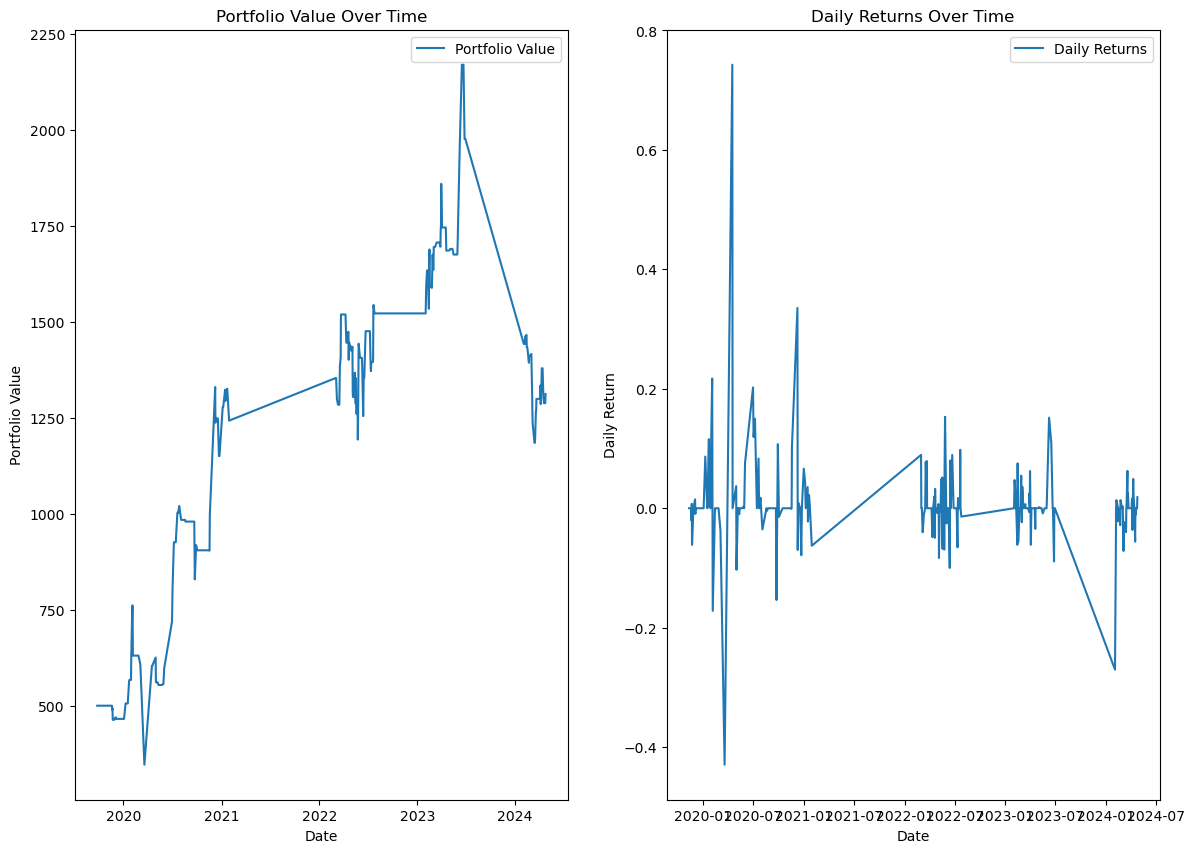

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))

# Portfolio Value over Time
plt.subplot(1, 2, 1)
plt.plot(date, portfolio_value, label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()

# Daily Returns
plt.subplot(1, 2, 2)
plt.plot(date[1:], daily_returns, label='Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns Over Time')
plt.legend()
plt.show()

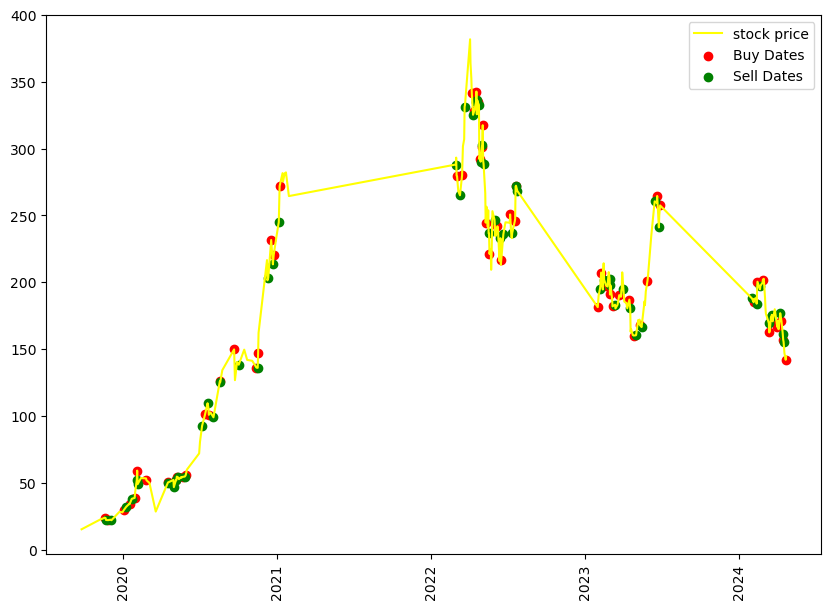

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(date,stock_final_prices,color="yellow",label="stock price")
plt.scatter(buy_time,buy_rate,color='r',label='Buy Dates')
plt.scatter(sell_time,sell_rate,color='g',label='Sell Dates')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()


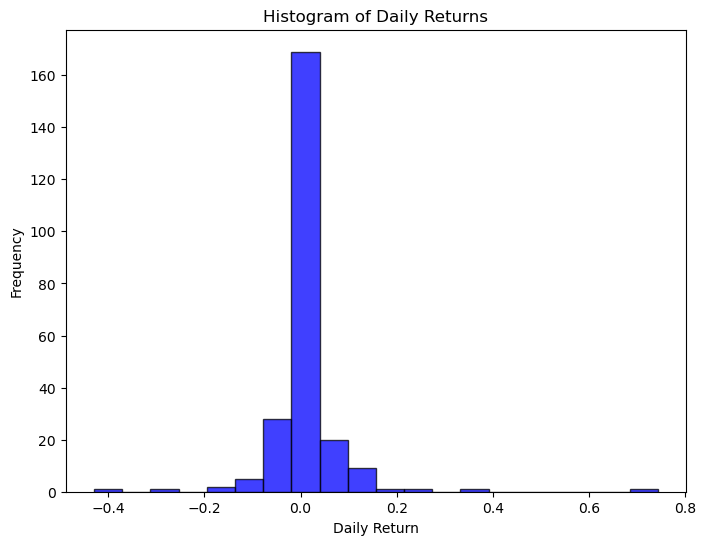

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(daily_returns, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Returns')
plt.show()